In [1]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

import os
import glob
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns;
from tqdm import tqdm

light_blue = '#56BEC1'
dark_blue = '#242D56'

In [2]:

PATH = r'Z:\projects\Emmett\Documents\writeup\fig_hippocampus_lesions_Lcurve\data\hippocampus\\'
out_path = r"Z:\projects\Emmett\Documents\writeup\fig_hippocampus_lesions_Lcurve\figs\\"

In [3]:
def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name,bbox_inches=0,transparent = True)
    plt.close()
    
    
def CreateSequences_Time(Transition_types,Transition_times,transition_reference_time,Transition_filter_time):
    # reoder transitions into time releveant sequences  
    seq_index = 0
    TimeFiltered_ids = [[]]
    TimeFiltered_times = [[]]
    Reference_times = [[]]

    for ind, transit in enumerate (Transition_types):
        if Transition_times[ind] < Transition_filter_time and Transition_times[ind] > 0.03: # if less than filter time and more than lower bound filter time (0.05s):
            TimeFiltered_ids[seq_index] = TimeFiltered_ids[seq_index] + [transit]
            TimeFiltered_times[seq_index] = TimeFiltered_times[seq_index] + [Transition_times[ind]]
            Reference_times[seq_index] = Reference_times[seq_index] + [transition_reference_time[ind]]
            

        else:
            if TimeFiltered_ids[seq_index]: # if not empty 
                seq_index = seq_index + 1
                TimeFiltered_ids = TimeFiltered_ids + [[]]
                TimeFiltered_times = TimeFiltered_times +[[]] 
                Reference_times = Reference_times + [[]]
                TimeFiltered_ids[seq_index] = TimeFiltered_ids[seq_index] + [transit]
                TimeFiltered_times[seq_index] = TimeFiltered_times[seq_index] + [Transition_times[ind]]   
                Reference_times[seq_index] = Reference_times[seq_index] + [transition_reference_time[ind]]
    return TimeFiltered_ids,TimeFiltered_times,Reference_times

def determime_heatmapdata(var,port1,port2,port3,port4):
    TransitionTypesIndex = np.array([11,12,13,14,15,16,17,18,21,22,23,24,25,26,27,28,31,32,33,34,35,36,37,38,41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,61,62,63,64,65,66,67,68,71,72,73,74,75,76,77,78,81,82,83,84,85,86,87,88])
    port1_transits = []
    for i in range(((port1*8)-8),((port1*8)-8)+8):
        port1_transits = port1_transits + [var[i]]

    port2_transits = []
    for i in range(((port2*8)-8),((port2*8)-8)+8):
        port2_transits = port2_transits + [var[i]]

    port3_transits = []
    for i in range(((port3*8)-8),((port3*8)-8)+8):
        port3_transits = port3_transits + [var[i]]

    port4_transits = []
    for i in range(((port4*8)-8),((port4*8)-8)+8):
        port4_transits = port4_transits + [var[i]]

    port_transits = [port1_transits] + [port2_transits] + [port3_transits] + [port4_transits]

    return port_transits


def determineTransitionNumber(TimeFiltered_seqs):
    TransitionTypesIndex = np.array([11,12,13,14,15,16,17,18,21,22,23,24,25,26,27,28,31,32,33,34,35,36,37,38,41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,61,62,63,64,65,66,67,68,71,72,73,74,75,76,77,78,81,82,83,84,85,86,87,88])
    trajects = []
    for inds, seqs in enumerate(TimeFiltered_seqs):
#         seqs = literal_eval(seqs) # convert back from weird df string conversion thing
        for ind, transits in enumerate(seqs):
#             if not str(transits)[0] == str(transits)[1]:
            trajects = np.append(trajects,transits)
    transition_number = []
    for transit_types in TransitionTypesIndex:
        temp = (np.where(trajects == float(transit_types)))
        transition_number.append(len(temp[0]))
    return transition_number

def reversedata(port_transits):

    reordered_port_transits = []
    for i in range(1,len(port_transits)+1):
        mylist = port_transits[-i]
        myorder = new_order
        mylist = [mylist[i] for i in myorder]
        newlist = []
        for item in mylist:
            newlist = newlist + [float(item)]
        reordered_port_transits = reordered_port_transits + [newlist]
    #restructure data to swap x and y axis:
    data = [[],[],[],[],[],[],[],[]]
    for ind in range(8):
        for index,item in enumerate(reordered_port_transits):
            data[ind] = data[ind] + [item[len(item)-1-ind]]
    for i in range(8):
        data[i].reverse()
    return data

def Find_Transition_times_sns(TransitionLatency_Tfilt,TransitionTypes_Tfilt,Transitions):
    transit_times = []
    transit_type = []
    for i,Transits in enumerate(Transitions):
        transit_times_temp = []
        for ind, transition_pair in enumerate(TransitionTypes_Tfilt):
            if transition_pair == Transits:
                transit_times_temp = transit_times_temp + [TransitionLatency_Tfilt[ind]]
                
        transit_times = transit_times + transit_times_temp
        transit_type = transit_type + len(transit_times_temp)*[i+1]
    return(transit_times,transit_type)

def determine_seq_scores_and_indicies(current_seq,variable_list):
    score = 0
    inds = []
    for item in variable_list:
        score= score + current_seq.count(item)
        current_inds = list(np.where(np.array(current_seq) == item)[0])
        inds = inds + current_inds
    return(score,inds)

In [4]:
PATH = r'Z:\projects\Emmett\Documents\writeup\fig_hippocampus_lesions_Lcurve\data\\'
AA_T_levels = []
AA_animals = []
AA_Type = []
AA_catagory= []

for file in os.listdir(PATH):
    
    print(file)
    
    control_path = os.path.join(PATH, file,'control')
    control_paths = glob.glob(control_path + '\*\AcrossSessions\AnalysisOutput\\')
    
    lesion_path = os.path.join(PATH, file,'lesions')
    lesion_paths = glob.glob(lesion_path + '\*\AcrossSessions\AnalysisOutput\\')
    
    lesion_T_levels = []
    for path in lesion_paths:
        with open (path + 'Training_levels' , 'rb') as fp:
            T_levels = pickle.load(fp)  
            lesion_T_levels = lesion_T_levels + [T_levels]
#         with open (path + 'TrialsPerSessions' , 'rb') as fp:
#             trials_per_session = pickle.load(fp)        
#             lesion_trials_per_session = lesion_trials_per_session + [trials_per_session]
                 
    AA_T_levels = AA_T_levels + lesion_T_levels
    AA_animals = AA_animals + os.listdir(PATH+file+'\\lesions')
    AA_Type = AA_Type + ([file] * len(os.listdir(PATH+file+'\\lesions')))
    AA_catagory = AA_catagory + ['lesion']* len(os.listdir(PATH+file+'\\lesions'))
            
    control_T_levels = []
    for path in control_paths:
        with open (path + 'Training_levels' , 'rb') as fp:
            T_levels = pickle.load(fp)     
            control_T_levels = control_T_levels + [T_levels]
#         with open (path + 'TrialsPerSessions' , 'rb') as fp:
#             trials_per_session = pickle.load(fp)        
#             control_trials_per_session = control_trials_per_session + [trials_per_session]
            
    AA_T_levels = AA_T_levels + control_T_levels 
    AA_animals = AA_animals + os.listdir(PATH+file+'\\control')
    AA_Type = AA_Type + ([file] * len(os.listdir(PATH+file+'\\control')))
    AA_catagory = AA_catagory + ['control']* len(os.listdir(PATH+file+'\\control'))
    
    
pl_data = pd.DataFrame({'animal':AA_animals,'type':AA_Type,'catagory':AA_catagory,'training_levels':AA_T_levels})

hippocampus


In [5]:


catagories = pl_data.catagory.values
animals = pl_data.animal.values
t_levels = pl_data.training_levels.values

lesion_mask = catagories == 'lesion'

TrialbyTrial_Pscores = conactinate_nth_items(list(t_levels[lesion_mask]))
lesion_MeanLearningCurve = []
lesion_std = []
for i,item in enumerate(TrialbyTrial_Pscores):
    lesion_MeanLearningCurve = lesion_MeanLearningCurve + [np.mean(item)]
    lesion_std = lesion_std + [np.std(item)]
    
control_mask = catagories == 'control'
    
TrialbyTrial_Pscores = conactinate_nth_items(list(t_levels[control_mask]))
control_MeanLearningCurve = []
control_std = []
for i,item in enumerate(TrialbyTrial_Pscores):
    control_MeanLearningCurve = control_MeanLearningCurve + [np.mean(item)]
    control_std = control_std + [np.std(item)]
    
    

%matplotlib inline  
################################################################################################################
## Training levels  
window = 10
xlim = 5000
################################################################################################################


fig,ax = plt.subplots(1, 1, figsize=(14, 7))


# for i in range(len(t_levels[lesion_mask])):
#     ax.plot(t_levels[lesion_mask][i],alpha = 0.3,color = dark_pink) 
# for i in range(len(t_levels[control_mask])):
#     ax.plot(t_levels[control_mask][i],alpha = 0.3,color = dark_blue) 

ax.set_xlim([0, xlim])
ax.set_ylim([1, 51])

print('Lesion n = ' + str(len(animals[lesion_mask])))
print('Control n = ' + str(len(animals[control_mask])))


ax.plot(convolve_movmean(control_MeanLearningCurve[0:xlim],window), '-',color = dark_blue,linewidth = 2)
ax.plot(convolve_movmean(lesion_MeanLearningCurve[0:xlim],window), '-',color = light_blue,linewidth = 2)
   
ax.set_title('Training levels across animals',fontsize = 20)
ax.set_xlabel('Trials',fontsize = 20)

ax.set_ylabel('Training level',fontsize = 20)

upper = np.array(lesion_MeanLearningCurve[0:xlim]) + np.array(lesion_std[0:xlim])
lower = np.array(lesion_MeanLearningCurve[0:xlim]) - np.array(lesion_std[0:xlim])

# cut off at 50 because of cieling effect 
for index,item in enumerate(upper):
    if item > 50:
        upper[index] = 50.0

ax.fill_between(list(range(0,len(upper))),(lower),(upper),
    alpha=0.2, edgecolor='None', facecolor=light_blue,
    linewidth=1, linestyle='dashdot', antialiased=True)

upper = np.array(control_MeanLearningCurve[0:xlim]) + np.array(control_std[0:xlim])
lower = np.array(control_MeanLearningCurve[0:xlim]) - np.array(control_std[0:xlim])

# cut off at 50 because of cieling effect 
for index,item in enumerate(upper):
    if item > 50:
        upper[index] = 50.0
        
ax.fill_between(list(range(0,len(upper))),(lower),(upper),
    alpha=0.2, edgecolor='None', facecolor=dark_blue,
    linewidth=1, linestyle='dashdot', antialiased=True)

# out_path = r'Z:\projects\Emmett\Documents\replay_paper\figures\figure5\\'
SaveFig('learning_curve.pdf',out_path)



Lesion n = 7
Control n = 6


In [6]:
### reshape into dataframe

# # cut trials down:
# cut = min(map(len, t_levels))
cut = 5000

new = []
group = []
cum_trials= []
animalid = []
for index,item in enumerate(t_levels):
    

    # hacky fix for missing data:
    if len(item) < cut:
        new += item + [50]*(cut - len(item))
        

    else:
        new = new + item[0:cut]
    print(len(item[0:cut]))
    
    if index < len(t_levels)/2:
        group = group + cut*['lesion']
    else:
        group = group + cut*['control']
        
    
    animalid = animalid + [animals[index]]*cut
        
    cum_trials = cum_trials + list(np.linspace(1,cut,cut))

    
df = pd.DataFrame({'CumTrials': cum_trials, 'Level':new, 'Group': group, 'ID':animalid})
    

5000
2004
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000


In [7]:
# parameters for the plotting
hue_order = ['control', 'lesion']
color_palette = [(0.24715576, 0.49918708, 0.57655991), (160/255, 11/255 , 11/255)]
sns.set_palette(color_palette)

# define a function to generate a list of experimental groups randomly
def generate_eg(list_size, prob, labs = hue_order):
    ltr = []
    for i in range(list_size):
        if random.random() < prob:
            ltr.append(labs[0])
        else:
            ltr.append(labs[1])
    return ltr

# define a 100-trial window to bin the data
xbin = 100
df["TrialIndexBinned"] = (df.CumTrials.values // xbin) * xbin + xbin / 2
print('Trials are binned in groups of', xbin)

# groupby so each animal has a mean of the performance in each bin
df_bintr = df.groupby(['ID','Group','TrialIndexBinned']).mean().reset_index()

# create a scaled version of the performance
# df_bintr['Performance'] = df_bintr.Level * 100
df_bintr['Performance'] = df_bintr.Level 

# calculate the differences of the means using the binned data
perdif_df = df_bintr[df_bintr.Group == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
            df_bintr[df_bintr.Group == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance']

Trials are binned in groups of 100


C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\3352013967.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  perdif_df = df_bintr[df_bintr.Group == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\3352013967.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bintr[df_bintr.Group == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance']


In [8]:
# Select the amount of times to shuffle. Originally this is done 10,000 times
# use a smaller number to speed things up
nsh = 10000
import random
# select the important columns
df_colsel = df_bintr[['ID', 'Group', 'TrialIndexBinned', 'Performance']].copy()
# get the experimental group for each animal
exp_gr = [df_colsel[df_colsel.ID==x].Group.unique()[0] for x in df_colsel.ID.unique()]
# get the number of mice
n_an = len(exp_gr)
# get the probability of a mouse to be a control for this dataset
cb_prob = sum([x==hue_order[0] for x in exp_gr]) / n_an
# set random seed
np.random.seed(124321)
# calculate the differences of means by resampling
shuff_res = []

for i in tqdm(range(nsh)):
    # shuffle the list of groups by assigning a probability for each mouse to be in a group based on the real ratio
    exp_grs = generate_eg(n_an, cb_prob)
    # create a diccionary
    egs_dict = dict(zip(df_colsel.ID.unique(), exp_grs))
    # create a new column with the shuffled group
    df_colsel['egs'] = [egs_dict[x] for x in df_colsel.ID]
    # calculate the differences and append
    shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
                     df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
# save in a data frame format
shrdf = pd.concat(shuff_res)


  0%|                                                                                                                                                                                                                                                                                           | 0/10000 [00:00<?, ?it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

  0%|▎                                                                                                                                                                                                                                                                                | 13/10000 [00:00<01:19, 125.60it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

  0%|▊                                                                                                                                                                                                                                                                                | 32/10000 [00:00<01:01, 161.95it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

  1%|█▊                                                                                                                                                                                                                                                                               | 67/10000 [00:00<01:09, 142.66it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

  1%|██▊                                                                                                                                                                                                                                                                             | 105/10000 [00:00<00:59, 166.88it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
  1%|███▍                                                                                                                                                                            

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

  1%|███▉                                                                                                                                                                                                                                                                            | 146/10000 [00:00<00:55, 176.38it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

  2%|█████                                                                                                                                                                                                                                                                           | 184/10000 [00:01<00:57, 171.95it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

  2%|█████▌                                                                                                                                                                                                                                                                          | 204/10000 [00:01<00:54, 178.40it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

  3%|███████▊                                                                                                                                                                                                                                                                        | 285/10000 [00:01<00:51, 186.98it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

  3%|████████▎                                                                                                                                                                                                                                                                       | 307/10000 [00:01<00:49, 194.80it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

  4%|██████████▌                                                                                                                                                                                                                                                                     | 387/10000 [00:02<00:59, 161.44it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

  4%|███████████▌                                                                                                                                                                                                                                                                    | 427/10000 [00:02<00:54, 175.15it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

  5%|████████████▌                                                                                                                                                                                                                                                                   | 463/10000 [00:02<00:55, 173.34it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
  5%|██████████████▋                                                                                                                                                                                                                                                                 | 539/10000 [00:03<00:52, 178.53it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be vali

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
  6%|███████████████▋                                                                                                                                                                

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

  7%|█████████████████▉                                                                                                                                                                                                                                                              | 659/10000 [00:03<00:52, 178.71it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

  7%|██████████████████▍                                                                                                                                                                                                                                                             | 678/10000 [00:03<00:54, 169.49it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

  7%|██████████████████▉                                                                                                                                                                                                                                                             | 698/10000 [00:04<00:52, 176.53it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

  8%|█████████████████████                                                                                                                                                                                                                                                           | 774/10000 [00:04<00:50, 184.06it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
  9%|████████████████████████▎                                                                                                                                                       

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 10%|███████████████████████████▋                                                                                                                                                                                                                                                   | 1023/10000 [00:05<00:43, 206.82it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 12%|███████████████████████████████▋                                                                                                                                                

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 12%|█████████████████████████████████▎                                                                                                                                              

 13%|█████████████████████████████████▉                                                                                                                                                                                                                                             | 1251/10000 [00:07<00:45, 190.93it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 13%|██████████████████████████████████▍                                                                                                                                             

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 13%|███████████████████████████████████▋                                                                                                                                            

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 14%|████████████████████████████████████▋                                                                                                                                                                                                                                          | 1355/10000 [00:07<00:45, 189.25it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 14%|█████████████████████████████████████▊                                                                                                                                                                                                                                         | 1395/10000 [00:07<00:44, 192.80it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 16%|██████████████████████████████████████████▋                                                                                                                                                                                                                                    | 1574/10000 [00:08<00:42, 198.56it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 16%|███████████████████████████████████████████▊                                                                                                                                                                                                                                   | 1616/10000 [00:08<00:41, 202.01it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 17%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                 | 1679/10000 [00:09<00:44, 185.80it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 17%|██████████████████████████████████████████████▌                                                                                                                                                                                                                                | 1720/10000 [00:09<00:44, 186.83it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 18%|███████████████████████████████████████████████▊                                                                                                                                                                                                                               | 1762/10000 [00:09<00:42, 191.65it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 18%|████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 1805/10000 [00:10<00:45, 180.04it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 18%|██████████████████████████████████████████████████                                                                                                                                                                                                                             | 1848/10000 [00:10<00:42, 192.59it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 19%|████████████████████████████████████████████████████▋                                                                                                                                                                                                                          | 1945/10000 [00:10<00:47, 167.84it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 20%|█████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 1988/10000 [00:11<00:46, 171.49it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 20%|██████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 2006/10000 [00:11<00:46, 172.33it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 21%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 2088/10000 [00:11<00:40, 194.74it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 21%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                                                     | 2127/10000 [00:11<00:50, 157.16it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 21%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                     | 2144/10000 [00:11<00:49, 158.39it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 22%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 2166/10000 [00:12<00:45, 173.11it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 23%|█████████████████████████████████████████████████████████████▋                                                                                                                  

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 24%|████████████████████████████████████████████████████████████████▊                                                                                                               

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 24%|█████████████████████████████████████████████████████████████████▎                                                                                                              

 24%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                             | 2428/10000 [00:13<00:41, 182.83it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 25%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 2520/10000 [00:14<00:43, 172.61it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 26%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                         | 2562/10000 [00:14<00:39, 189.94it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 26%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 2604/10000 [00:14<00:37, 198.21it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 26%|███████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 2624/10000 [00:14<00:37, 196.35it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 26%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 2644/10000 [00:14<00:40, 181.96it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be vali

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 27%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                     | 2702/10000 [00:15<00:43, 169.07it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 27%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                     | 2725/10000 [00:15<00:39, 183.50it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be vali

 27%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                    | 2744/10000 [00:15<00:41, 176.94it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 28%|███████████████████████████████████████████████████████████████████████████▍                                                                                                    

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 28%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                  | 2845/10000 [00:15<00:37, 191.13it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 29%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 2949/10000 [00:16<00:37, 185.59it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 30%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 3007/10000 [00:16<00:37, 184.64it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 30%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                            | 3045/10000 [00:17<00:38, 178.38it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 31%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                            | 3063/10000 [00:17<00:39, 177.19it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 31%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                          | 3105/10000 [00:17<00:36, 190.28it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 31%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                          | 3127/10000 [00:17<00:34, 198.09it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 31%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                         | 3147/10000 [00:17<00:42, 160.54it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 32%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 3165/10000 [00:17<00:43, 155.69it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 32%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                        | 3209/10000 [00:18<00:36, 183.81it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 32%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 3249/10000 [00:18<00:36, 185.83it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 33%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 3270/10000 [00:18<00:35, 192.11it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 33%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                     | 3295/10000 [00:18<00:32, 206.60it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 33%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                     | 3316/10000 [00:18<00:35, 188.61it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 34%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                    | 3358/10000 [00:18<00:35, 188.96it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 34%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 3378/10000 [00:18<00:34, 191.79it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be vali

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 34%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 3398/10000 [00:19<00:35, 184.18it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 34%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 3421/10000 [00:19<00:33, 196.57it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 34%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                 | 3441/10000 [00:19<00:34, 190.59it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 35%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 35%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                | 3481/10000 [00:19<00:35, 185.73it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 35%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 36%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 36%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                             | 3598/10000 [00:20<00:35, 178.15it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 37%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 3680/10000 [00:20<00:31, 197.63it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 37%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 3720/10000 [00:20<00:34, 183.36it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          

 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 3758/10000 [00:20<00:35, 175.45it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 3783/10000 [00:21<00:32, 194.18it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 3823/10000 [00:21<00:33, 186.18it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 3915/10000 [00:21<00:36, 166.26it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                   | 3978/10000 [00:22<00:31, 193.50it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 4021/10000 [00:22<00:29, 201.28it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be vali

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 4042/10000 [00:22<00:31, 190.85it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 4083/10000 [00:22<00:30, 192.07it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 4127/10000 [00:22<00:31, 187.75it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 4168/10000 [00:23<00:30, 191.10it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 4210/10000 [00:23<00:29, 198.45it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 4254/10000 [00:23<00:27, 208.21it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 4296/10000 [00:23<00:28, 202.33it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 4519/10000 [00:25<00:31, 173.82it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 4559/10000 [00:25<00:29, 185.20it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 4598/10000 [00:25<00:29, 181.03it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 4778/10000 [00:26<00:29, 174.28it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 4858/10000 [00:27<00:40, 128.07it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 4879/10000 [00:27<00:35, 145.41it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 4940/10000 [00:27<00:29, 174.02it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 4964/10000 [00:27<00:26, 190.19it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 5105/10000 [00:28<00:27, 179.59it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 5145/10000 [00:28<00:26, 180.70it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be vali

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 5187/10000 [00:28<00:26, 180.02it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 5206/10000 [00:28<00:27, 175.94it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 5226/10000 [00:29<00:26, 181.05it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 5247/10000 [00:29<00:25, 189.12it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 5289/10000 [00:29<00:23, 197.99it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 5373/10000 [00:29<00:23, 196.48it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5438/10000 [00:30<00:22, 205.82it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 5459/10000 [00:30<00:24, 187.22it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 5480/10000 [00:30<00:23, 190.87it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 5500/10000 [00:30<00:24, 185.60it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 5577/10000 [00:30<00:24, 180.78it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 5660/10000 [00:31<00:22, 194.64it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 5701/10000 [00:31<00:22, 195.09it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 5743/10000 [00:31<00:21, 194.23it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be vali

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 5765/10000 [00:31<00:21, 199.48it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 5809/10000 [00:32<00:21, 194.26it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 5849/10000 [00:32<00:22, 187.26it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 5930/10000 [00:32<00:22, 177.23it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 6014/10000 [00:33<00:22, 181.07it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 6034/10000 [00:33<00:21, 185.51it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 6054/10000 [00:33<00:21, 181.04it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 6160/10000 [00:34<00:19, 196.35it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 6227/10000 [00:34<00:17, 210.43it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 6359/10000 [00:35<00:18, 197.85it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 6400/10000 [00:35<00:18, 190.58it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 6423/10000 [00:35<00:17, 199.83it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 6466/10000 [00:35<00:18, 189.85it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 6546/10000 [00:36<00:18, 184.98it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 6585/10000 [00:36<00:20, 167.51it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 6625/10000 [00:36<00:19, 175.96it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 6660/10000 [00:36<00:22, 148.96it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 6676/10000 [00:36<00:21, 151.72it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 6710/10000 [00:37<00:20, 157.40it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 6752/10000 [00:37<00:17, 183.31it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 6792/10000 [00:37<00:18, 172.30it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 6833/10000 [00:37<00:17, 182.43it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 6917/10000 [00:38<00:16, 186.60it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6957/10000 [00:38<00:16, 184.63it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 7020/10000 [00:38<00:14, 200.13it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 7060/10000 [00:38<00:16, 180.62it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be vali

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 7106/10000 [00:39<00:14, 204.79it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 7289/10000 [00:40<00:14, 182.88it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 7416/10000 [00:40<00:12, 210.97it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be vali

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 7438/10000 [00:40<00:12, 199.16it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 7596/10000 [00:41<00:14, 168.27it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 7618/10000 [00:41<00:13, 181.72it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be vali

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 7678/10000 [00:42<00:12, 181.24it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be vali

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 7697/10000 [00:42<00:12, 181.15it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 7721/10000 [00:42<00:11, 195.87it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 7762/10000 [00:42<00:11, 190.26it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 7786/10000 [00:42<00:10, 203.07it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 7807/10000 [00:42<00:10, 203.33it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 7830/10000 [00:43<00:10, 207.47it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7852/10000 [00:43<00:10, 209.14it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 7894/10000 [00:43<00:10, 200.84it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 7958/10000 [00:43<00:10, 193.39it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 7997/10000 [00:43<00:11, 174.94it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 8034/10000 [00:44<00:12, 161.72it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 8092/10000 [00:44<00:10, 177.08it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 8343/10000 [00:45<00:08, 185.81it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 8422/10000 [00:46<00:08, 185.06it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 8441/10000 [00:46<00:08, 185.26it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 8460/10000 [00:46<00:08, 179.55it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 8481/10000 [00:46<00:08, 187.35it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 8523/10000 [00:46<00:07, 194.71it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 8603/10000 [00:47<00:08, 168.98it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 8623/10000 [00:47<00:07, 175.89it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 8763/10000 [00:48<00:06, 181.22it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8933/10000 [00:49<00:05, 188.11it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8954/10000 [00:49<00:05, 193.84it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 9098/10000 [00:50<00:04, 186.45it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 9142/10000 [00:50<00:04, 195.54it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 9307/10000 [00:51<00:03, 182.37it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9465/10000 [00:52<00:03, 174.83it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9486/10000 [00:52<00:02, 184.82it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9505/10000 [00:52<00:02, 185.75it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9547/10000 [00:52<00:02, 195.30it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9668/10000 [00:53<00:02, 163.08it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9685/10000 [00:53<00:01, 158.75it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9727/10000 [00:53<00:01, 181.87it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9830/10000 [00:53<00:00, 192.48it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9952/10000 [00:54<00:00, 196.09it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9973/10000 [00:54<00:00, 199.48it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns w

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1474724595.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nu

In [9]:
real_data = df_colsel[df_colsel.Group == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
            df_colsel[df_colsel.Group == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance']

real_data = real_data*-1
print('Data is shuffled', nsh, 'times')

#plot
pos_ci = shrdf.groupby('TrialIndexBinned').quantile(.95)
neg_ci = shrdf.groupby('TrialIndexBinned').quantile(.05)

fig2 = plt.figure(figsize=(10, 10))
plt.axhline(0, ls='dotted', alpha=0.4, color='k')
plt.plot(real_data, color='#30A6C3', label='observed data')
plt.plot(pos_ci, linestyle='--', color='grey', label='95% ci')
plt.plot(neg_ci, linestyle='--', color='grey')
x = pos_ci.reset_index().TrialIndexBinned
y1 = neg_ci.reset_index().Performance
y2 = real_data.reset_index().Performance
plt.fill_between(x, y1, y2, where=y2 <= y1, facecolor='#30A6C3', alpha=.3, interpolate=True)
plt.ylabel('Performance difference (levels)')
# plt.ylabel('performance difference (%)')
plt.xlabel('trial number')
plt.legend(loc=(0.75,0.05), frameon=False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim((0,5000))


fig2.show()

SaveFig('shuffle.pdf',out_path)


C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\2310877892.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  real_data = df_colsel[df_colsel.Group == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\2310877892.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_colsel[df_colsel.Group == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance']


Data is shuffled 10000 times


C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\2310877892.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


In [10]:


## GRM2
catagories = pl_data.catagory.values
animals = pl_data.animal.values
t_levels = pl_data.training_levels.values
lesion_mask = catagories == 'lesion'
control_mask = catagories == 'control'

dls_c_max_l = []
dls_c_t_reached = []
for item in t_levels[control_mask]:
    dls_c_max_l = dls_c_max_l+ [max(item[0:cut])]
    dls_c_t_reached = dls_c_t_reached + [np.where(np.array(item) == max(item[0:cut]))[0][0]]
    
dls_l_max_l = []
dls_l_t_reached = []
for item in t_levels[lesion_mask]:
    dls_l_max_l = dls_l_max_l+ [max(item[0:cut])]
    dls_l_t_reached = dls_l_t_reached + [np.where(np.array(item) == max(item[0:cut]))[0][0]]

not enough samples for normality test, assumed normally distributed
------
DLS trials to max diff
Ttest_indResult(statistic=0.3547087980260788, pvalue=0.7295146477275934)
DLS max level diff
Ttest_indResult(statistic=nan, pvalue=nan)


C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\3810502073.py:37: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(scipy.stats.ttest_ind(plot_df4.max_level[plot_df4.DLS_groups == 'control'],plot_df4.max_level[plot_df4.DLS_groups == 'lesion']))


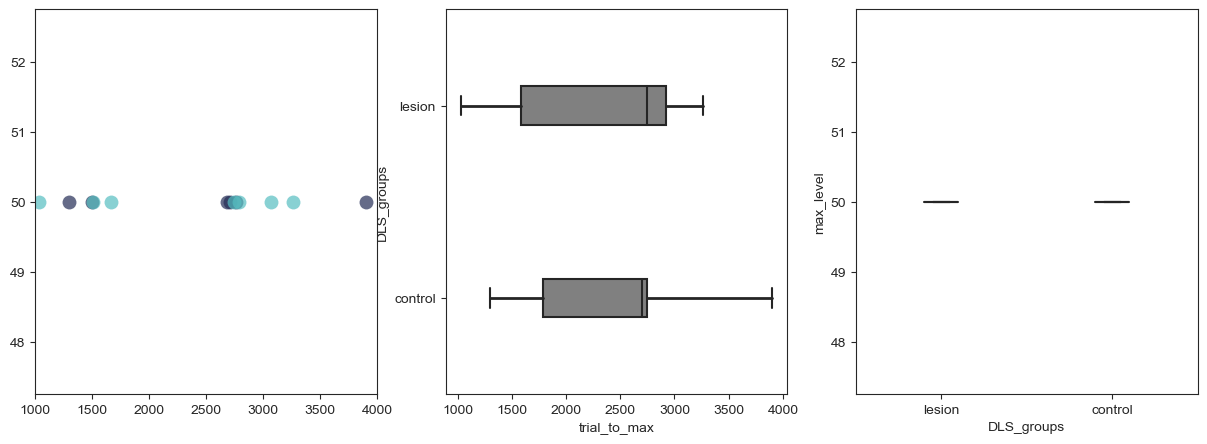

In [29]:
## Plot 
import scipy




fig,[ax3,ax4,ax5] = plt.subplots(1, 3, figsize=(15, 5))


ax3.set_xlim([1000, 4000])
# ax3.set_ylim([30, 51])

ax3.plot(dls_c_t_reached,dls_c_max_l,'o',color = dark_blue,markersize = 10,alpha = 0.7, markeredgewidth = 0)
ax3.plot(dls_l_t_reached,dls_l_max_l,'o',color = light_blue,markersize = 10,alpha = 0.7, markeredgewidth = 0)

plot_df3 = pd.DataFrame({'DLS_groups': ['lesion']*len(dls_l_t_reached) + ['control']*len(dls_c_t_reached),'trial_to_max': dls_l_t_reached+dls_c_t_reached})
ax4=sns.boxplot( x = 'trial_to_max', y = 'DLS_groups', data = plot_df3, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'grey', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'h',ax = ax4)

plot_df4 = pd.DataFrame({'DLS_groups': ['lesion']*len(dls_l_t_reached) + ['control']*len(dls_c_t_reached),'max_level': dls_l_max_l+dls_c_max_l})
ax5=sns.boxplot( y = 'max_level', x = 'DLS_groups', data = plot_df4, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'#30A6C3', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax5)



# SaveFig('trials_to_max.pdf',out_path)

print('not enough samples for normality test, assumed normally distributed') 
print('------')
print('DLS trials to max diff')
print(scipy.stats.ttest_ind(plot_df3.trial_to_max[plot_df3.DLS_groups == 'control'],plot_df3.trial_to_max[plot_df3.DLS_groups == 'lesion']))
print('DLS max level diff')
print(scipy.stats.ttest_ind(plot_df4.max_level[plot_df4.DLS_groups == 'control'],plot_df4.max_level[plot_df4.DLS_groups == 'lesion']))

# SaveFig('max_level.pdf',out_path)

In [55]:
data

group  animal                            training_level_by_trial  \
0   control  EJT187  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1   control  EJT191  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2   control  EJT213  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3   control  EJT214  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4   control  EJT227  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
5   control  EJT228  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
6   lesions  EJT248  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
7   lesions  EJT249  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
8   lesions  EJT250  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
9   lesions  EJT255  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
10  lesions  EJT256  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
11  lesions  EJT262  [1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, ...   
12  lesions  EJT263  [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, ...   

                                   trials_per_session  
0   [53, 102, 60, 64, 69, 146, 123, 163, 209, 68, ...  
1   [74, 113, 127, 120, 124, 272, 354, 422, 480, 6...  
2   [66, 85, 23, 63, 134, 97, 141, 205, 309, 325, ...  
3   [86, 65, 70, 119, 143, 270, 256, 276, 274, 186...  
4   [40, 26, 28, 91, 3, 3, 59, 55, 198, 117, 142, ...  
5   [17, 69, 80, 92, 66, 71, 95, 132, 244, 79, 198...  
6   [90, 5, 136, 293, 236, 426, 401, 382, 393, 526...  
7              [111, 4, 139, 317, 127, 282, 623, 401]  
8   [141, 213, 294, 468, 647, 664, 347, 502, 687, ...  
9   [100, 154, 500, 534, 440, 401, 375, 505, 639, ...  
10  [136, 274, 638, 696, 515, 617, 582, 688, 814, ...  
11  [4, 5, 263, 180, 287, 593, 714, 768, 1087, 419...  
12  [7, 13, 14, 168, 490, 856, 727, 820, 779, 557,...

In [12]:
### repeat errors? 

## run trhough and load last session for all mice, work out repeat error for each session 

In [54]:
# Define groups and path
groups = ['control', 'lesions']
data_path = r'Z:\projects\Emmett\Documents\writeup\fig_hippocampus_lesions_Lcurve\data\hippocampus\\'

# Initialize empty DataFrame
data = pd.DataFrame({'group': [], 'animal': [], 'training_level_by_trial': [], 'trials_per_session': []})

all_paths= []
# Iterate over groups
for group in groups:
    # Build path
    path = f"{data_path}/{group}/*/AcrossSessions/AnalysisOutput/"
    preproc_path = f"{data_path}/{group}/*/Preprocessed/"
    
    # Find all paths matching the pattern
    paths = glob.glob(path)
    preproc_paths = glob.glob(preproc_path)
    
    all_paths+=preproc_paths
    # Iterate over paths
    for p in paths:
        # Extract animal name from path
        animal = p.split('\\')[-4]
        # Load training levels
        with open(p + 'Training_levels', 'rb') as fp:
            training_levels = pickle.load(fp)
        # Load trials per session
        with open(p + 'TrialsPerSessions', 'rb') as fp:
            trials_per_session = pickle.load(fp)
        
        # Append data to DataFrame
        data = data.append({'group': group, 'animal': animal, 'training_level_by_trial': training_levels, 'trials_per_session': trials_per_session}, ignore_index=True)
        
        

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1804124499.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'group': group, 'animal': animal, 'training_level_by_trial': training_levels, 'trials_per_session': trials_per_session}, ignore_index=True)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1804124499.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'group': group, 'animal': animal, 'training_level_by_trial': training_levels, 'trials_per_session': trials_per_session}, ignore_index=True)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\1804124499.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'group': group, 'animal': animal, 'training_leve

In [59]:
        

port1 = 2
port2 = 1
port3 = 6
port4 = 3
port5 = 7

AA_Port_transits = []
AA_Time_filter = []
AA_TransitionTypes_unfilt = []
AA_TransitionLatency_unfilt = []
AA_Start_Poke_out_time = []
AA_trial_id = []
AA_session_str = []

# Iterate through the rows of the DataFrame
for _, row in data.iterrows():
    
    all_sessions= os.listdir(all_paths[_])
    # Build path
    path = r" r'Z:\projects\Emmett\Documents\writeup\fig_hippocampus_lesions_Lcurve\data\hippocampus\\"
    # Find all paths matching the pattern
    sessions = glob.glob(path + "\\")

    # Find the start and end indices of the 4000-4500 trial range
    s = 4000
    e = 5000
    
    # Initialize lists to store data
    Port_transits = []
    Time_filter = []
    TransitionTypes_unfilt = []
    TransitionLatency_unfilt = []
    Start_Poke_out_time = []
    trial_id = []
    session_str = []
            
    cum_sum = np.cumsum(row.trials_per_session)
    print(cum_sum)
    if cum_sum[-1] > 4999:
        first_session = np.where(cum_sum < s)[0][-1]
        last_session = np.where(cum_sum > e)[0][0]
        start_remainder = s - cum_sum[first_session]
        end_remainder = cum_sum[last_session] - e
        sessions = all_sessions[first_session + 1:last_session + 1]

        # set counter
        count = 0

        # Iterate over sessions
        for session in sessions:
            # Load data
            data_ = pd.read_csv(all_paths[_]+session + '\\PreProcessed_TransitionData.csv')

            # Select rows within the 4000-4500 trial range
            if session == sessions[0]:
                # Remove trials before 4000
                #if only 1 session:
                if len(sessions) == 1: 
                    a = data_.Trial_id.values >= start_remainder 
                    b = data_.Trial_id.values <= data_.Trial_id.values[-1] - end_remainder 
                    mask = a * b
                # otherwise:
                else:
                    mask = data_.Trial_id.values >= start_remainder
            elif session == sessions[-1]:
                # Remove trials after 4500
                mask = data_.Trial_id.values <= data_.Trial_id.values[-1] - end_remainder
            else:
                # Keep all trials
                mask = np.ones(len(data_), dtype=bool)

            #track trials added
            count += len(data_[mask].Trial_id.unique())

            # Extract data from selected rows
            Time_filter += list(data_[mask].loc[:, '2s_Time_Filter_out_in'])
            TransitionTypes_unfilt += list(data_[mask].loc[:, 'Transition_type'])
            TransitionLatency_unfilt += list(data_[mask].loc[:, 'out_in_Latency'])
            Start_Poke_out_time += list(data_[mask].Start_Poke_out_time.values)
            trial_id += list(data_[mask].Trial_id.values)
            session_str += [session.split('\\')[-1].split('_')[0]] * len(data_[mask].Trial_id.values)


    AA_Start_Poke_out_time += [Start_Poke_out_time]
    AA_Time_filter += [Time_filter]
    AA_TransitionTypes_unfilt += [TransitionTypes_unfilt]
    AA_TransitionLatency_unfilt += [TransitionLatency_unfilt]
    AA_trial_id += [trial_id]
    AA_session_str += [session_str]
    print('should ~ 500  :    ' +  str(count))



concat_data= []
for i in range(len(AA_TransitionTypes_unfilt)):
    new_row = [AA_session_str[i],AA_trial_id[i],AA_TransitionTypes_unfilt[i],AA_TransitionLatency_unfilt[i],AA_Time_filter[i],AA_Start_Poke_out_time[i]]
    concat_data.append(new_row)

df = pd.DataFrame(concat_data, columns = ['trials_4000to5000_session','trials_4000to5000_trial_id','trials_4000to5000_transitions','trials_4000to5000_latency','trials_4000to5000_2s_timefilter','trials_4000to5000_relativestarttime'])

data = pd.concat([data, df], axis=1)

### special case for this data 
data = data.drop(7)

[  53  155  215  279  348  494  617  780  989 1057 1368 1676 1888 2188
 2701 3053 3501 4095 4506 4985 5343 5834 6149 6493 7016 7554 8055 8708
 9268]
should ~ 500  :    1001
[  74  187  314  434  558  830 1184 1606 2086 2785 3091 3337 3708 4096
 4608 5013]
should ~ 500  :    1001
[  66  151  174  237  371  468  609  814 1123 1448 1714 2071 2247 2604
 2984 3398 3806 4271 4729 6053]
should ~ 500  :    1001
[  86  151  221  340  483  753 1009 1285 1559 1745 2033 2394 2755 2941
 3155 3366 3597 3968 4229 4527 4751 5258 5625 6186]
should ~ 500  :    1001
[   40    66    94   185   188   191   250   305   503   620   762   882
  1045  1383  1653  1934  2329  2353  2737  3125  3458  3780  3837  4157
  4712  5139  5607  5847  6368  7047  7723  8354  9103  9608 10335 10902
 11476 12163 12807 13760 14121 15082 15682 16355]
should ~ 500  :    1001
[   17    86   166   258   324   395   490   622   866   945  1143  1254
  1336  1506  1679  1775  2096  2703  3410  3959  4446  4756  5427  5889
  6646 

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\3968146127.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_rate_df = error_rate_df.append(tempt_df)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\3968146127.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_rate_df = error_rate_df.append(tempt_df)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\3968146127.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_rate_df = error_rate_df.append(tempt_df)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\3968146127.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_rate_df = error_rate_df.append(tempt_

ShapiroResult(statistic=0.8520140647888184, pvalue=0.16340498626232147)
ShapiroResult(statistic=0.9295759201049805, pvalue=0.5768309235572815)
so I use paramteric comparisions test:
Ttest_indResult(statistic=0.9599519307752863, pvalue=0.35971450349274114)


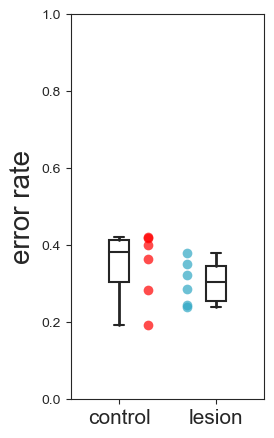

In [39]:
error_rate_df = pd.DataFrame({'animal':[],'group':[],'correct_rate':[],'error_rate':[],'neural_rate':[]})

Correct = [21,16,63,37,72]
Error = [22,23,24,25,26,27,28,11,12,13,14,15,17,18,61,62,64,65,66,67,68,31,32,33,34,35,36,38,71,73,74,75,76,77,78]
Neutral = [41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,81,82,83,84,85,86,87,88]

for _, row in data.iterrows():
    #pull data from dfs:
    TransitionTypes_unfilt = np.array(row.trials_4000to5000_transitions)
    TransitionLatency_unfilt = np.array(row.trials_4000to5000_latency)

    # filter out transitions that are too slow (defined in preprocessing as 2s) and filter out transitions that are too fast (negative - this is probably a hardware error)   
    filter_mask = (np.array(TransitionLatency_unfilt) > 0) * (np.array(TransitionLatency_unfilt) < 2)
    TransitionTypes_Tfilt  = TransitionTypes_unfilt[filter_mask]
    TransitionLatency_Tfilt  = TransitionLatency_unfilt[filter_mask]

    c_score = determine_seq_scores_and_indicies(list(TransitionTypes_Tfilt),Correct)[0]/len(TransitionTypes_Tfilt)
    e_score = determine_seq_scores_and_indicies(list(TransitionTypes_Tfilt),Error)[0]/len(TransitionTypes_Tfilt)
    n_score = determine_seq_scores_and_indicies(list(TransitionTypes_Tfilt),Neutral)[0]/len(TransitionTypes_Tfilt)

    tempt_df = pd.DataFrame({'animal':[row.animal],'group':[row.group],'correct_rate':[c_score],'error_rate':[e_score],'neural_rate':[n_score]})
    error_rate_df = error_rate_df.append(tempt_df)
    


type_ = ['c_error_rate']*len(list(error_rate_df[error_rate_df.group == 'control'].error_rate.values)) + ['l_error_rate']*len(list(error_rate_df[error_rate_df.group == 'lesions'].error_rate.values))
scores = list(error_rate_df[error_rate_df.group == 'control'].error_rate.values) + list(error_rate_df[error_rate_df.group == 'lesions'].error_rate.values)
plt_df = pd.DataFrame({'group':type_,'score':scores})


fig, ax = plt.subplots(1, 1,figsize=(2.5,5))

color = 'red'
x = [0.3] *6
ax.plot(x, error_rate_df[error_rate_df.group == 'control'].error_rate.values,'o',markersize = 7, c = color, alpha = 0.7,markeredgewidth = 0)

color = '#2FA7C4'
x = [0.7] *6
ax.plot(x, error_rate_df[error_rate_df.group == 'lesions'].error_rate.values,'o',markersize = 7, c = color,alpha = 0.7,markeredgewidth = 0)


ax=sns.boxplot( y = 'score', x = 'group', data = plt_df, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

ax.set_xticklabels(('control', 'lesion'), fontsize = 15)
ax.set_xlabel('',size = 20)
ax.set_ylabel('error rate',size = 20)

ax.set_ylim(0,1)

a = error_rate_df[error_rate_df.group == 'control'].error_rate.values
b = error_rate_df[error_rate_df.group == 'lesions'].error_rate.values

# print('one group has a p of less than 0.05 so is not normally distributed')
print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
print('so I use paramteric comparisions test:')
print(scipy.stats.ttest_ind(a,b))


# SaveFig('error rate.pdf',out_path)

In [33]:
error_rate_df

animal    group  correct_rate  error_rate  neural_rate
0  EJT187  control      0.804246    0.191695     0.004059
0  EJT191  control      0.564578    0.421938     0.013483
0  EJT213  control      0.710570    0.284284     0.005146
0  EJT214  control      0.626671    0.363419     0.009909
0  EJT227  control      0.592579    0.400641     0.006780
0  EJT228  control      0.568370    0.418407     0.013223
0  EJT248  lesions      0.753850    0.243801     0.002349
0  EJT250  lesions      0.757735    0.239427     0.002838
0  EJT255  lesions      0.697315    0.285955     0.016730
0  EJT256  lesions      0.637649    0.352048     0.010304
0  EJT262  lesions      0.607626    0.381025     0.011349
0  EJT263  lesions      0.663178    0.323455     0.013367

In [16]:
c_data = data[data.group == 'control']
l_data = data[data.group == 'lesions']
#reset index
l_data = l_data.reset_index()

c_AA_Port_transits = []
for i in range(len(c_data.animal.values)):
    TimeFiltered_ids,TimeFiltered_times,Reference_times = CreateSequences_Time(c_data.trials_4000to5000_transitions[0],c_data.trials_4000to5000_latency[0],c_data.trials_4000to5000_relativestarttime[0],Transition_filter_time = 2.0)
    Port_transits = determime_heatmapdata(determineTransitionNumber(TimeFiltered_ids),port1,port2,port3,port4)
    c_AA_Port_transits = c_AA_Port_transits + [Port_transits]
l_AA_Port_transits = []
for i in range(len(l_data.animal.values)):
    TimeFiltered_ids,TimeFiltered_times,Reference_times = CreateSequences_Time(l_data.trials_4000to5000_transitions[0],l_data.trials_4000to5000_latency[0],l_data.trials_4000to5000_relativestarttime[0],Transition_filter_time = 2.0)
    Port_transits = determime_heatmapdata(determineTransitionNumber(TimeFiltered_ids),port1,port2,port3,port4)
    l_AA_Port_transits = l_AA_Port_transits + [Port_transits]



Port_transits = [c_AA_Port_transits,l_AA_Port_transits]

nrow = 1 
ncol = 2
fig, axs = plt.subplots(nrow, ncol,figsize=(20, 10))
for ind, ax in enumerate(fig.axes):

    AA_data= []
    for animal in Port_transits[ind]:
        flat_list = []
        for s_port in animal:
            normalised = list(np.array(s_port) / sum(s_port))
            flat_list = flat_list + normalised

        AA_data = AA_data + [flat_list]
    concat_AA_data = conactinate_nth_items(AA_data)

    # recreate transition matrix: 
    means= [[]]*4
    count = 0
    index = 0
    for item in concat_AA_data:
        means[index] = means[index] + [np.mean(item)]
        count = count + 1
        if count == 8:
            count = 0
            index = index + 1

    a = np.array([0,1,2,3,4,5,6,7])
    a = np.delete(a, [port1-1,port2-1,port3-1,port4-1,port5-1])
    new_order = [port1-1] + [port2-1] + [port3-1] + [port4-1] + [port5-1] + list(a)

    mean_Port_transits = reversedata(means)    
    x_axis_labels = ['Port 1','Port 2','Port 3','Port 4'] # labels for x-axis
    y_axis_labels = ['Port Z','Port Y','Port X','Port 5','Port 4','Port 3','Port 2','Port 1'] # labels for y-axis
    labels =  np.array([['','','',''],
                        ['','','',''],
                        ['','','',''],
                        ['','','','T4'],
                        ['','','T3',''],
                        ['','T2','',''],
                        ['T1','','',''],
                        ['','','','']])

    mask = np.zeros_like(mean_Port_transits)

    #plot:
    with sns.axes_style("white"):
        h1 = sns.heatmap(mean_Port_transits,xticklabels=x_axis_labels, yticklabels=y_axis_labels, 
                        linewidths=.5, mask=mask, square=True,cmap="YlGnBu",annot = labels,fmt = '',cbar_kws = dict(use_gridspec=False,location="right"), ax = ax)

    #add seprrating line:
    ax.hlines([3], *ax.get_ylim())
    ax.set_ylabel('End Port',size = 20)
    ax.set_xlabel('Start Port',size = 20)
    
    ax.set_title(['control', 'lesion'][ind], size = 20)

#save fig
SaveFig('transition_hist.pdf',out_path)

In [17]:
data = data.reset_index()

In [18]:
## for each session pull out all the first ports that was entered, for the last transiton also take the second one as it wont appear in a subsequent transition
AA_port_proportions= []

for animal in range(len(data.animal.values)):
    ports= []
    for session in np.unique(data.trials_4000to5000_session[animal]):
        session_mask = np.array(data.trials_4000to5000_session[animal]) == session
        for index, transit in enumerate(np.array(data.trials_4000to5000_transitions[animal])[session_mask]):
            ports = ports + [int(str(transit)[0])]
            if index == len(np.array(data.trials_4000to5000_transitions[animal])[session_mask])-1:
                ports = ports + [int(str(transit)[-1])]

    port_proportions=[data.group[animal],data.animal.values[animal]]
    for i in range(1,9):
        port_proportions = port_proportions + [sum(np.array(ports) == i)/len(ports)]

    AA_port_proportions = AA_port_proportions + [port_proportions]

poke_proportions_df = pd.DataFrame(AA_port_proportions, columns = ['group','animal','p1','p2','p3','p4','p5','p6','p7','p8'])

masks = [poke_proportions_df.group == 'control',poke_proportions_df.group == 'lesions']

nrow = 1 
ncol = 2
fig, axs = plt.subplots(nrow, ncol,figsize=(12, 5))
for ind, ax in enumerate(fig.axes):
    
    mask = masks[ind]

    ax.set_ylim([0, 5])
    ax.set_xlim([0, 5])

    colormap = plt.cm.get_cmap('YlGnBu') # 'plasma' or 'viridis'


    color_vals = [np.mean(poke_proportions_df[mask].p1),np.mean(poke_proportions_df[mask].p2),np.mean(poke_proportions_df[mask].p3),np.mean(poke_proportions_df[mask].p4),
                  np.mean(poke_proportions_df[mask].p5),np.mean(poke_proportions_df[mask].p6),np.mean(poke_proportions_df[mask].p7),np.mean(poke_proportions_df[mask].p8)]

    normalised_colour = np.array(color_vals)/max(color_vals)

    x = [1,2,3,4,1,2,3,4]
    y = [2,2,2,2,3.2,3.2,3.2,3.2]

    circles_ = []
    for i in range(8):
        color_ = colormap(normalised_colour[i])
        circles_ = circles_ + [plt.Circle((x[i], y[i]), 0.4,fill=True, linewidth=5, color = color_)]
    for i in range(8):
        ax.add_artist(circles_[i])

    plt.axis('off')
    ax.set_title(['control', 'lesion'][ind], size=20)

    # sc = plt.scatter(x, y, c=colors)

    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=0, vmax=max(color_vals))
    plt.text(5,1,('max val is '+ str(max(color_vals))),size=10)

    plt.colorbar(sm,fraction=0.02, pad=0.04,ax = ax)


# poke_data = [poke_proportions_df.p1.values,poke_proportions_df.p2.values,poke_proportions_df.p3.values,poke_proportions_df.p4.values,
#               poke_proportions_df.p5.values,poke_proportions_df.p6.values,poke_proportions_df.p7.values,poke_proportions_df.p8.values]


# # SaveFig('PokeProportions.svg',r'Z:\projects\Emmett\Documents\writeup\fig1_behaviour_figures\figs\\')

# nrow = 2 
# ncol = 4
# fig, axs = plt.subplots(nrow, ncol,figsize=(20, 5))

# for ind, ax in enumerate(fig.axes):

#     ax.plot(poke_data[ind],np.zeros(len(animals)),'o',alpha = 0.4, color = dark_blue,markersize = 10)
#     ax.plot(color_vals[ind],0,'|',color = dark_pink,markersize = 40, markeredgewidth = 5)
#     ax.set_xlim([0, np.max(poke_data)])
    
#     ax.set_title('Port ' + str(ind + 1), size=20)

poke_proportions_df= poke_proportions_df[poke_proportions_df.group == 'lesions']

SEM = [scipy.stats.sem(poke_proportions_df.p1),scipy.stats.sem(poke_proportions_df.p2),scipy.stats.sem(poke_proportions_df.p3),scipy.stats.sem(poke_proportions_df.p4),
              scipy.stats.sem(poke_proportions_df.p5),scipy.stats.sem(poke_proportions_df.p6),scipy.stats.sem(poke_proportions_df.p7),scipy.stats.sem(poke_proportions_df.p8)]

print('mean ratios per port: ' + str(np.array(color_vals)*100))
print('SEM per port: ' + str(np.array(SEM)*100))


SaveFig('poke_props.pdf',out_path)



C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\4082453288.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('YlGnBu') # 'plasma' or 'viridis'


mean ratios per port: [20.30314524 17.47392163 21.05239206  0.28929757  0.56654627 18.68506292
 21.36289142  0.26674289]
SEM per port: [0.70247693 0.84147065 0.73614824 0.06428583 0.18602465 0.85052225
 0.66068044 0.08530157]


C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\4183445086.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df= plot_df.append(tempt_df)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\4183445086.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot2_df= plot2_df.append(tempt_df)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\4183445086.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df= plot_df.append(tempt_df)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\4183445086.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot2_df= plot2_df.append(tempt_df)
C:\Users\Emmett\AppData\Local\Temp\ipykernel

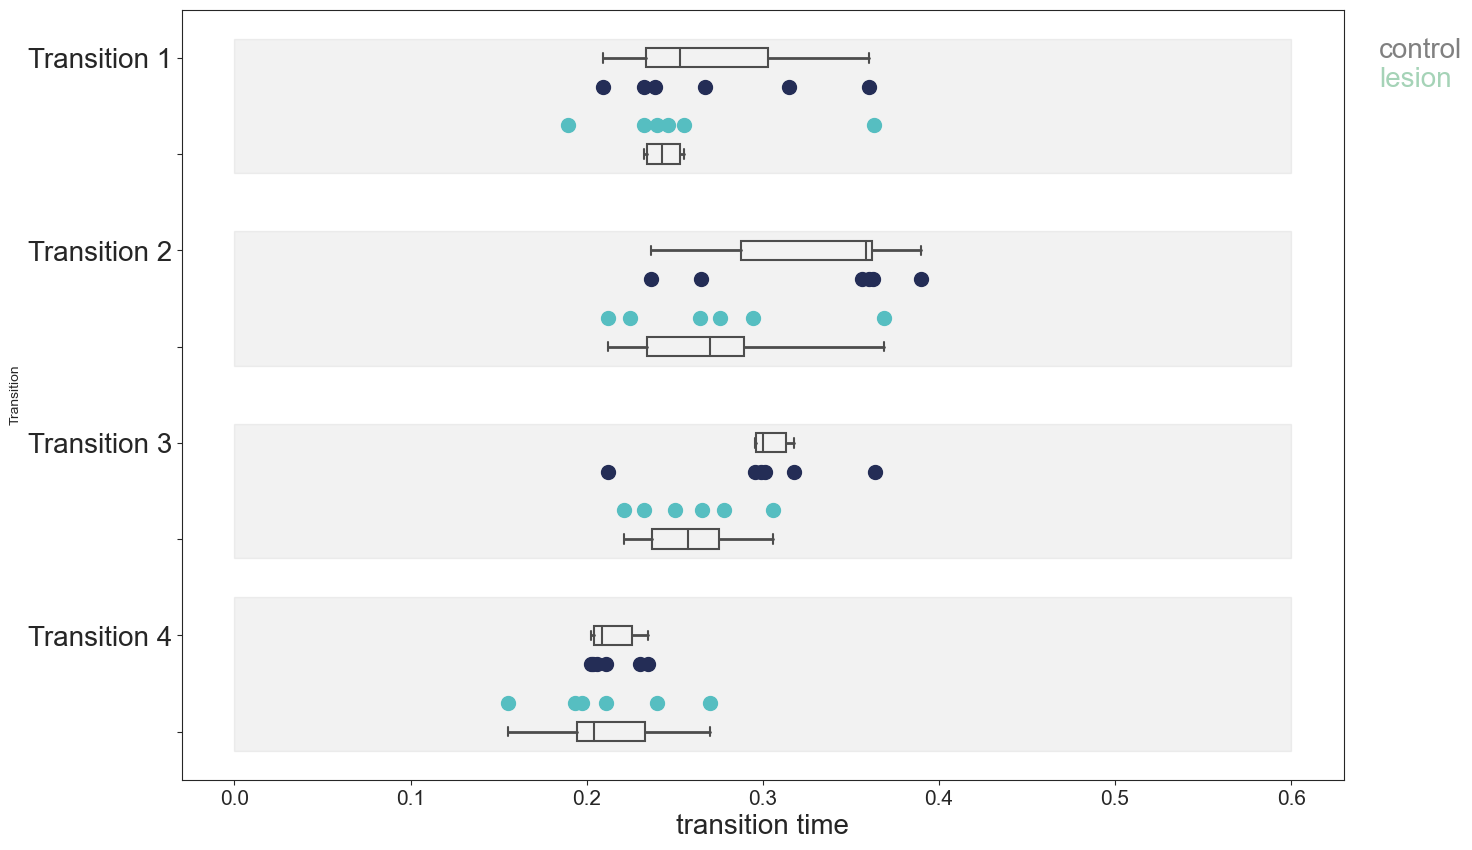

In [19]:
import statistics

sns.set_style("ticks")
masks = [data.group == 'control',data.group == 'lesions']

nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 10))
for ind, ax in enumerate(fig.axes):
    sns.axes_style()
    
    plot_df = pd.DataFrame({'mouse':[],'group':[],'Transition':[],'Time':[]})
    plot2_df = pd.DataFrame({'mouse':[],'group':[],'Transition':[],'sdevs':[]})
    
    for ind in range (2):

        mask = masks[ind]
        Transitions = [21,16,63,37]

        for _, row in data[mask].iterrows():

            #pull data from dfs:
            TransitionTypes_unfilt = np.array(row.trials_4000to5000_transitions)
            TransitionLatency_unfilt = np.array(row.trials_4000to5000_latency)

            # filter out transitions that are too slow (defined in preprocessing as 2s) and filter out transitions that are too fast (negative - this is probably a hardware error)   
            filter_mask = (np.array(TransitionLatency_unfilt) > 0) * (np.array(TransitionLatency_unfilt) < 2)
            TransitionTypes_Tfilt  = TransitionTypes_unfilt[filter_mask]
            TransitionLatency_Tfilt  = TransitionLatency_unfilt[filter_mask]

            Transition_Latencies, transition_type = Find_Transition_times_sns(TransitionLatency_Tfilt,TransitionTypes_Tfilt,Transitions)
            if transition_type: #if its not empty
                df = pd.DataFrame({'Transition' : transition_type,'Time':Transition_Latencies})
            sdevs = [statistics.stdev(df.Time[df.Transition.values == 1]),statistics.stdev(df.Time[df.Transition.values == 2]),statistics.stdev(df.Time[df.Transition.values == 3]),statistics.stdev(df.Time[df.Transition.values == 4])]
            means = [np.mean(df.Time[df.Transition.values == 1]),np.mean(df.Time[df.Transition.values == 2]),np.mean(df.Time[df.Transition.values == 3]),np.mean(df.Time[df.Transition.values == 4])]
            t_code = [[0,2,4,6],[1,3,5,7]]
            tempt_df = pd.DataFrame({'mouse':[_]*len(sdevs) , 'group':[row.group]*len(sdevs),'Transition':t_code[ind],'Time':means})
            plot_df= plot_df.append(tempt_df)
            
            sdevs = [statistics.stdev(df.Time[df.Transition.values == 1]),statistics.stdev(df.Time[df.Transition.values == 2]),statistics.stdev(df.Time[df.Transition.values == 3]),statistics.stdev(df.Time[df.Transition.values == 4])]
            t_code = [[0,2,4,6],[1,3,5,7]]
            tempt_df = pd.DataFrame({'mouse':[_]*len(sdevs) , 'group':[row.group]*len(sdevs),'Transition':t_code[ind],'sdevs':sdevs})
            plot2_df= plot2_df.append(tempt_df)

        ### 
    

    for i in range(8):
        x = np.ones(len(plot_df.Time[plot_df.Transition == i])) *[0.3, 0.7,2.3,2.7,4.3,4.7,6.3,6.7][i]
        if i%2 == 0:
            color = dark_blue
        else:
            color = light_blue
        ax.plot(plot_df.Time[plot_df.Transition == i],x,'o',markersize = 10, c = color)
    

    ax=sns.boxplot (x = 'Time', y = 'Transition', data = plot_df, color = 'grey', width = .2, zorder = 10,\
                showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                   saturation = 1, orient = 'h',ax = ax)

    ax.set_xlabel('transition time',size = 20)

    ax.tick_params(axis="x", labelsize=15)
    
    ax.text(0.65,0,'control',size=20, color = 'grey')
    ax.text(0.65,0.3,'lesion',size=20,color = '#A5D3B7')
    
#     ax.fill_between(0,1,1,
#     alpha=0.2, edgecolor='None', facecolor='#BE575F',
#     linewidth=1, linestyle='dashdot', antialiased=True)
    
    plt.fill_betweenx([-0.2,1.2], 0, 0.6, color='grey', alpha=.1)
    plt.fill_betweenx([1.8,3.2], 0, 0.6, color='grey', alpha=.1)
    plt.fill_betweenx([3.8,5.2], 0, 0.6, color='grey', alpha=.1)
    plt.fill_betweenx([5.6,7.2], 0, 0.6, color='grey', alpha=.1)
    
    ax.set_yticklabels(['Transition 1','','Transition 2','','Transition 3','','Transition 4','' ], fontsize = 20)



# SaveFig('transition_times.pdf',out_path)

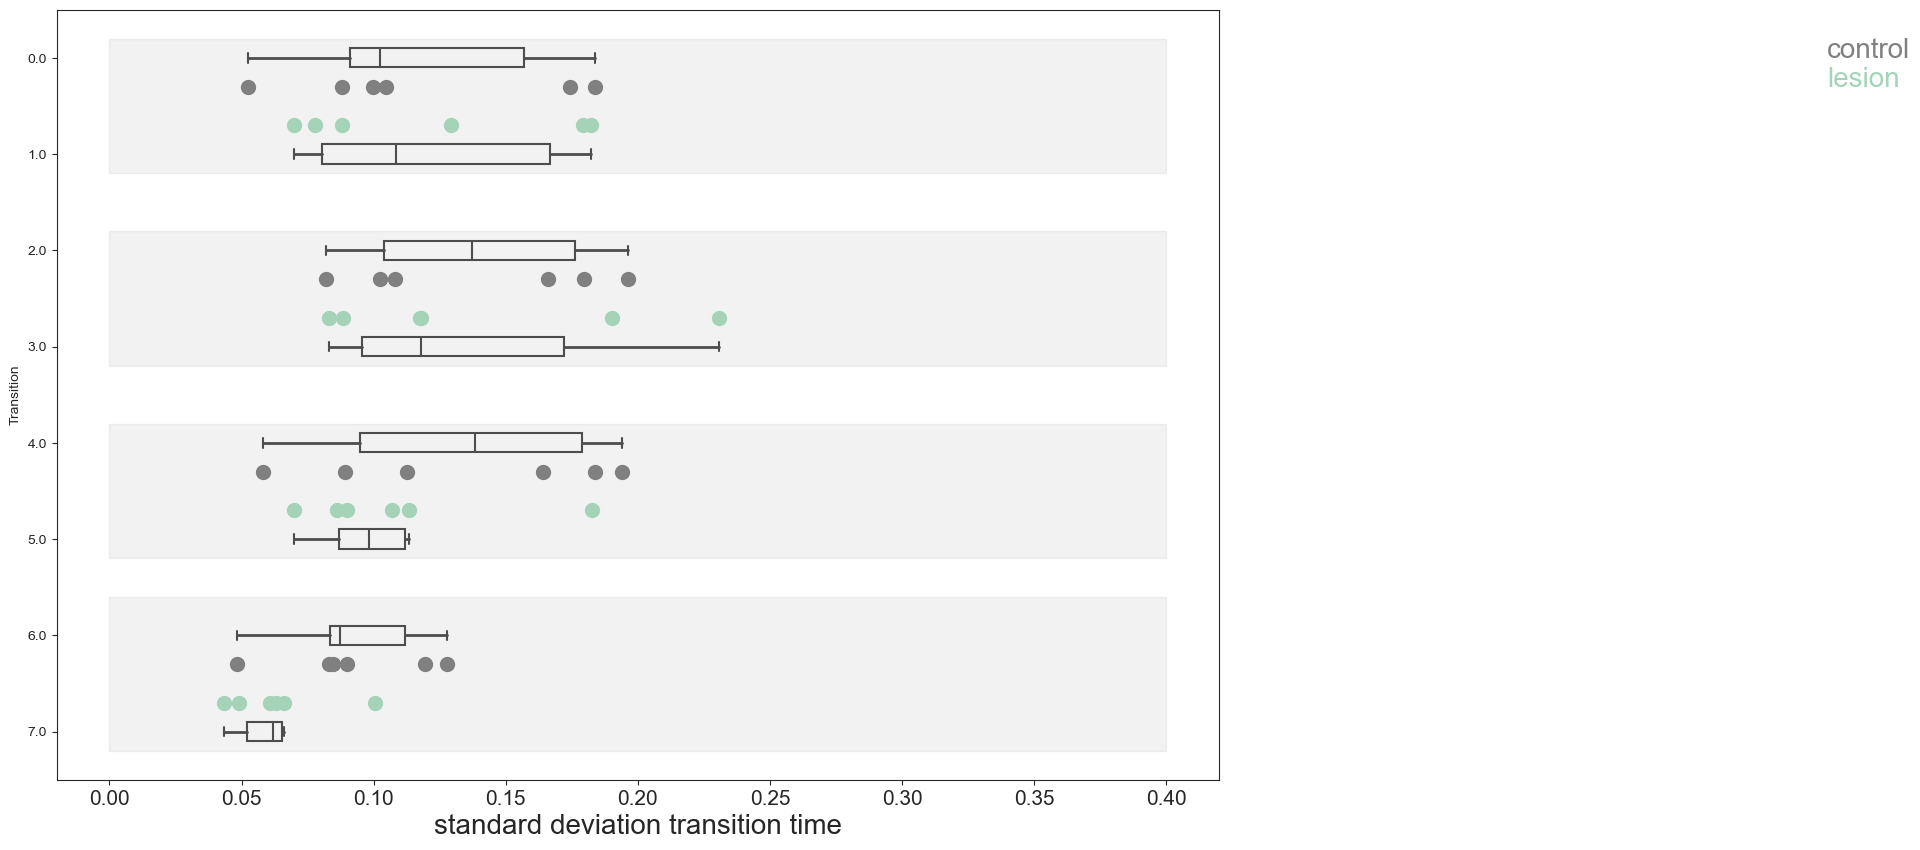

In [20]:
nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 10))
for ind, ax in enumerate(fig.axes):
    sns.axes_style()
    
for i in range(8):
    x = np.ones(len(plot2_df.sdevs[plot2_df.Transition == i])) *[0.3, 0.7,2.3,2.7,4.3,4.7,6.3,6.7][i]
    if i%2 == 0:
        color = 'grey'
    else:
        color = '#A5D3B7'
    ax.plot(plot2_df.sdevs[plot2_df.Transition == i],x,'o',markersize = 10, c = color)


ax=sns.boxplot (x = 'sdevs', y = 'Transition', data = plot2_df, color = 'grey', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'h',ax = ax)

ax.set_xlabel('standard deviation transition time',size = 20)

ax.tick_params(axis="x", labelsize=15)

ax.text(0.65,0,'control',size=20, color = 'grey')
ax.text(0.65,0.3,'lesion',size=20,color = '#A5D3B7')

#     ax.fill_between(0,1,1,
#     alpha=0.2, edgecolor='None', facecolor='#BE575F',
#     linewidth=1, linestyle='dashdot', antialiased=True)

plt.fill_betweenx([-0.2,1.2], 0, 0.4, color='grey', alpha=.1)
plt.fill_betweenx([1.8,3.2], 0, 0.4, color='grey', alpha=.1)
plt.fill_betweenx([3.8,5.2], 0, 0.4, color='grey', alpha=.1)
plt.fill_betweenx([5.6,7.2], 0, 0.4, color='grey', alpha=.1)
    

neither group has a p of less than 0.05 so is normally distributed
ShapiroResult(statistic=0.968956470489502, pvalue=0.8853526711463928)
ShapiroResult(statistic=0.9916203022003174, pvalue=0.9927535057067871)
so I use non paramteric comparisions test:
Ttest_indResult(statistic=1.2929097275493782, pvalue=0.22511364369844872)


(0.0, 0.5)

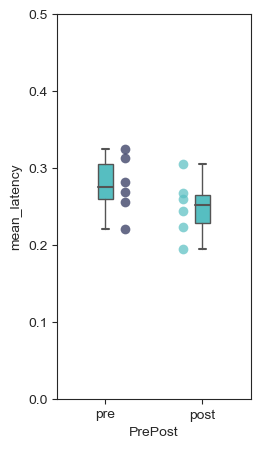

In [26]:

lesion_means = []
working_df = plot_df[plot_df.group == 'lesions']
for mouse in working_df.mouse.unique().astype(int):
    lesion_means += [np.mean(working_df[working_df.mouse == mouse].Time)]
    
control_means = []
working_df = plot_df[plot_df.group == 'control']
for mouse in working_df.mouse.unique().astype(int):
    control_means += [np.mean(working_df[working_df.mouse == mouse].Time)]


ort = 'v'

fig,ax = plt.subplots(1, 1, figsize=(2.5, 5))
ax.plot([0.2]*len(control_means),control_means,'o',color ='#272D56',markeredgecolor = 'none',alpha = 0.7, markersize = 7,markeredgewidth=0)
ax.plot([0.8]*len(lesion_means),lesion_means,'o',color ='#56BEC1',markeredgecolor = 'none',alpha = 0.7, markersize = 7,markeredgewidth=0)


plotting_df = pd.DataFrame({'PrePost':['pre']*len(control_means) + ['post']*len(lesion_means) ,'mean_latency': control_means + lesion_means})

ax=sns.boxplot( x = 'PrePost', y = 'mean_latency', data = plotting_df, color = '#56BEC1', width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'#56BEC1', "zorder":10,'linewidth':1},\
showfliers=False, whiskerprops = {'linewidth':1, "zorder":10},\
   saturation = 1, orient = ort, ax = ax)


a = control_means
b = lesion_means
print('neither group has a p of less than 0.05 so is normally distributed')
print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
print('so I use  paramteric comparisions test:')
print(scipy.stats.ttest_ind(a,b))

ax.set_ylim(0,0.5)
# SaveFig('transition_times.pdf',out_path)

neither group has a p of less than 0.05 so is normally distributed
ShapiroResult(statistic=0.9735903739929199, pvalue=0.915626049041748)
ShapiroResult(statistic=0.8317214846611023, pvalue=0.11115434020757675)
so I use non paramteric comparisions test:
Ttest_indResult(statistic=0.638588841231865, pvalue=0.5374405109219829)


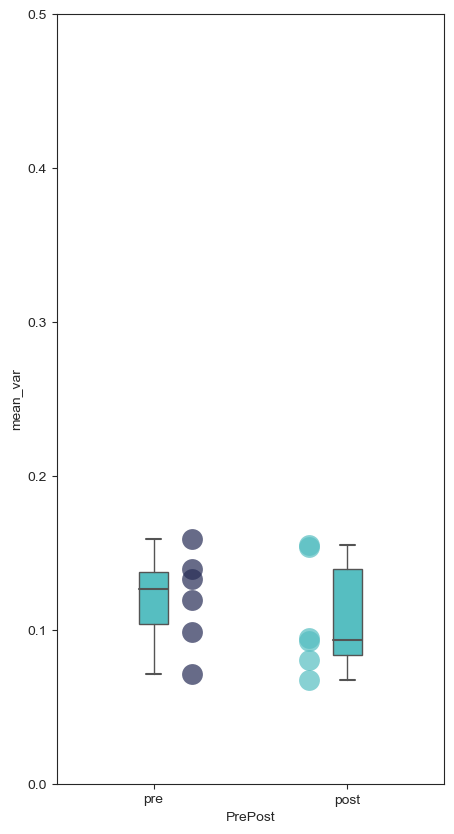

In [22]:

lesion_means = []
working_df = plot2_df[plot2_df.group == 'lesions']
for mouse in working_df.mouse.unique().astype(int):
    lesion_means += [np.mean(working_df[working_df.mouse == mouse].sdevs)]
    
control_means = []
working_df = plot2_df[plot2_df.group == 'control']
for mouse in working_df.mouse.unique().astype(int):
    control_means += [np.mean(working_df[working_df.mouse == mouse].sdevs)]


ort = 'v'

fig,ax = plt.subplots(1, 1, figsize=(5, 10))
ax.plot([0.2]*len(control_means),control_means,'o',color ='#272D56',markeredgecolor = 'none',alpha = 0.7, markersize = 15,markeredgewidth=0)
ax.plot([0.8]*len(lesion_means),lesion_means,'o',color ='#56BEC1',markeredgecolor = 'none',alpha = 0.7, markersize = 15,markeredgewidth=0)

ax.set_ylim(0,0.5)


plotting_df = pd.DataFrame({'PrePost':['pre']*len(control_means) + ['post']*len(lesion_means) ,'mean_var': control_means + lesion_means})

ax=sns.boxplot( x = 'PrePost', y = 'mean_var', data = plotting_df, color = '#56BEC1', width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'#56BEC1', "zorder":10,'linewidth':1},\
showfliers=False, whiskerprops = {'linewidth':1, "zorder":10},\
   saturation = 1, orient = ort, ax = ax)


a = control_means
b = lesion_means
print('neither group has a p of less than 0.05 so is normally distributed')
print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
print('so I use non paramteric comparisions test:')
print(scipy.stats.ttest_ind(a,b))

# SaveFig('mean_std.pdf',r'Z:\projects\Emmett\Documents\writeup\fig2_GRM2_lesions\figs\\')

In [23]:
plot2_df
plot2_df

mouse    group  Transition     sdevs
0    0.0  control         0.0  0.099731
1    0.0  control         2.0  0.081819
2    0.0  control         4.0  0.058011
3    0.0  control         6.0  0.048261
0    1.0  control         0.0  0.183901
1    1.0  control         2.0  0.166150
2    1.0  control         4.0  0.089114
3    1.0  control         6.0  0.119286
0    2.0  control         0.0  0.088001
1    2.0  control         2.0  0.108005
2    2.0  control         4.0  0.193837
3    2.0  control         6.0  0.089747
0    3.0  control         0.0  0.174267
1    3.0  control         2.0  0.196228
2    3.0  control         4.0  0.183796
3    3.0  control         6.0  0.082985
0    4.0  control         0.0  0.052428
1    4.0  control         2.0  0.102488
2    4.0  control         4.0  0.112539
3    4.0  control         6.0  0.127908
0    5.0  control         0.0  0.104695
1    5.0  control         2.0  0.179590
2    5.0  control         4.0  0.164189
3    5.0  control         6.0  0.084655
0    6.0  lesions         1.0  0.087968
1    6.0  lesions         3.0  0.088407
2    6.0  lesions         5.0  0.086080
3    6.0  lesions         7.0  0.060861
0    7.0  lesions         1.0  0.077811
1    7.0  lesions         3.0  0.117412
2    7.0  lesions         5.0  0.113289
3    7.0  lesions         7.0  0.062956
0    8.0  lesions         1.0  0.182375
1    8.0  lesions         3.0  0.190053
2    8.0  lesions         5.0  0.182746
3    8.0  lesions         7.0  0.065863
0    9.0  lesions         1.0  0.129218
1    9.0  lesions         3.0  0.118064
2    9.0  lesions         5.0  0.089713
3    9.0  lesions         7.0  0.043158
0   10.0  lesions         1.0  0.179187
1   10.0  lesions         3.0  0.230815
2   10.0  lesions         5.0  0.106832
3   10.0  lesions         7.0  0.100587
0   11.0  lesions         1.0  0.069927
1   11.0  lesions         3.0  0.083206
2   11.0  lesions         5.0  0.069788
3   11.0  lesions         7.0  0.049058

In [ ]:
#transition variability



# print('post' + str(i))
# print(scipy.stats.normaltest(pre_transition_std))

# print('pre' + str(i))
# print(scipy.stats.normaltest(post_transition_std))

print('---- too few samples, assumed normal')

print(scipy.stats.ttest_rel(pre_transition_std,post_transition_std))
    
# SaveFig('stand_dev.pdf',r'Z:\projects\Emmett\Documents\writeup\fig1_striatum_lesions\figs\\')

In [116]:
### plot av transiton time and standard dev

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\2742060730.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_rate_df = error_rate_df.append(tempt_df)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\2742060730.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_rate_df = error_rate_df.append(tempt_df)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\2742060730.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_rate_df = error_rate_df.append(tempt_df)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\2742060730.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_rate_df = error_rate_df.append(tempt_

ValueError: x and y must have same first dimension, but have shapes (7,) and (6,)

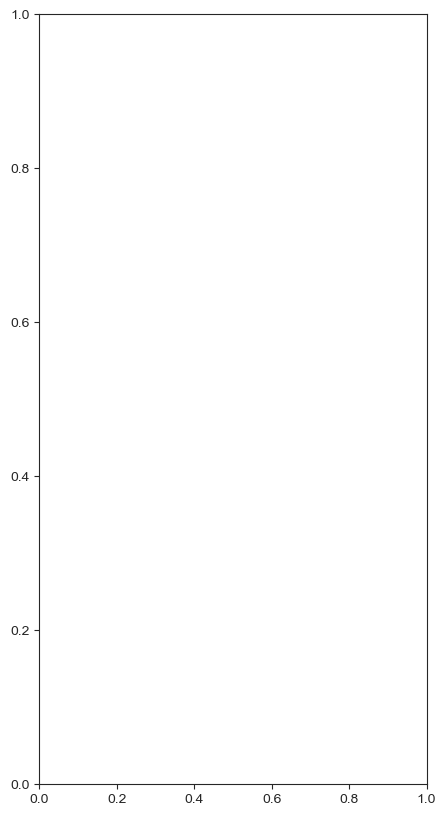

In [24]:
error_rate_df = pd.DataFrame({'animal':[],'group':[],'correct_rate':[],'error_rate':[],'neural_rate':[]})

Correct = [21,16,63,37,72]
Error = [22,23,24,25,26,27,28,11,12,13,14,15,17,18,61,62,64,65,66,67,68,31,32,33,34,35,36,38,71,73,74,75,76,77,78]
Neutral = [41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,81,82,83,84,85,86,87,88]

for _, row in data.iterrows():
    #pull data from dfs:
    TransitionTypes_unfilt = np.array(row.trials_4000to5000_transitions)
    TransitionLatency_unfilt = np.array(row.trials_4000to5000_latency)

    # filter out transitions that are too slow (defined in preprocessing as 2s) and filter out transitions that are too fast (negative - this is probably a hardware error)   
    filter_mask = (np.array(TransitionLatency_unfilt) > 0) * (np.array(TransitionLatency_unfilt) < 2)
    TransitionTypes_Tfilt  = TransitionTypes_unfilt[filter_mask]
    TransitionLatency_Tfilt  = TransitionLatency_unfilt[filter_mask]

    c_score = determine_seq_scores_and_indicies(list(TransitionTypes_Tfilt),Correct)[0]/len(TransitionTypes_Tfilt)
    e_score = determine_seq_scores_and_indicies(list(TransitionTypes_Tfilt),Error)[0]/len(TransitionTypes_Tfilt)
    n_score = determine_seq_scores_and_indicies(list(TransitionTypes_Tfilt),Neutral)[0]/len(TransitionTypes_Tfilt)

    tempt_df = pd.DataFrame({'animal':[row.animal],'group':[row.group],'correct_rate':[c_score],'error_rate':[e_score],'neural_rate':[n_score]})
    error_rate_df = error_rate_df.append(tempt_df)
    


# error_rate_df[mask].correct_rate

type_ = ['c_error_rate']*len(list(error_rate_df[error_rate_df.group == 'control'].error_rate.values)) + ['l_error_rate']*len(list(error_rate_df[error_rate_df.group == 'lesions'].error_rate.values))
scores = list(error_rate_df[error_rate_df.group == 'control'].error_rate.values) + list(error_rate_df[error_rate_df.group == 'lesions'].error_rate.values)
plt_df = pd.DataFrame({'group':type_,'score':scores})


fig, ax = plt.subplots(1, 1,figsize=(5,10))

color = 'grey'
x = [0.3] *7
ax.plot(x, error_rate_df[error_rate_df.group == 'control'].error_rate.values,'o',markersize = 10, c = color)

color = '#A5D3B7'
x = [0.7] *9
ax.plot(x, error_rate_df[error_rate_df.group == 'lesions'].error_rate.values,'o',markersize = 10, c = color)


ax=sns.boxplot( y = 'score', x = 'group', data = plt_df, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

ax.set_xticklabels(('control', 'lesion'), fontsize = 15)
ax.set_xlabel('',size = 20)
ax.set_ylabel('error rate',size = 20)


# SaveFig('Performance_pre_post_boxplots.svg',r'Z:\projects\Emmett\Documents\writeup\fig1_striatum_lesions\figs\\')

In [118]:
## this error rate seems wrong?? why is the value so high for controls? 

In [119]:
len(list(error_rate_df[error_rate_df.group == 'control'].error_rate.values))

7

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\2810351644.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_breakdown_df = error_breakdown_df.append(tempt_df)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\2810351644.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_breakdown_df = error_breakdown_df.append(tempt_df)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\2810351644.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_breakdown_df = error_breakdown_df.append(tempt_df)
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23460\2810351644.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_breakdo

ValueError: x and y must have same first dimension, but have shapes (7,) and (6,)

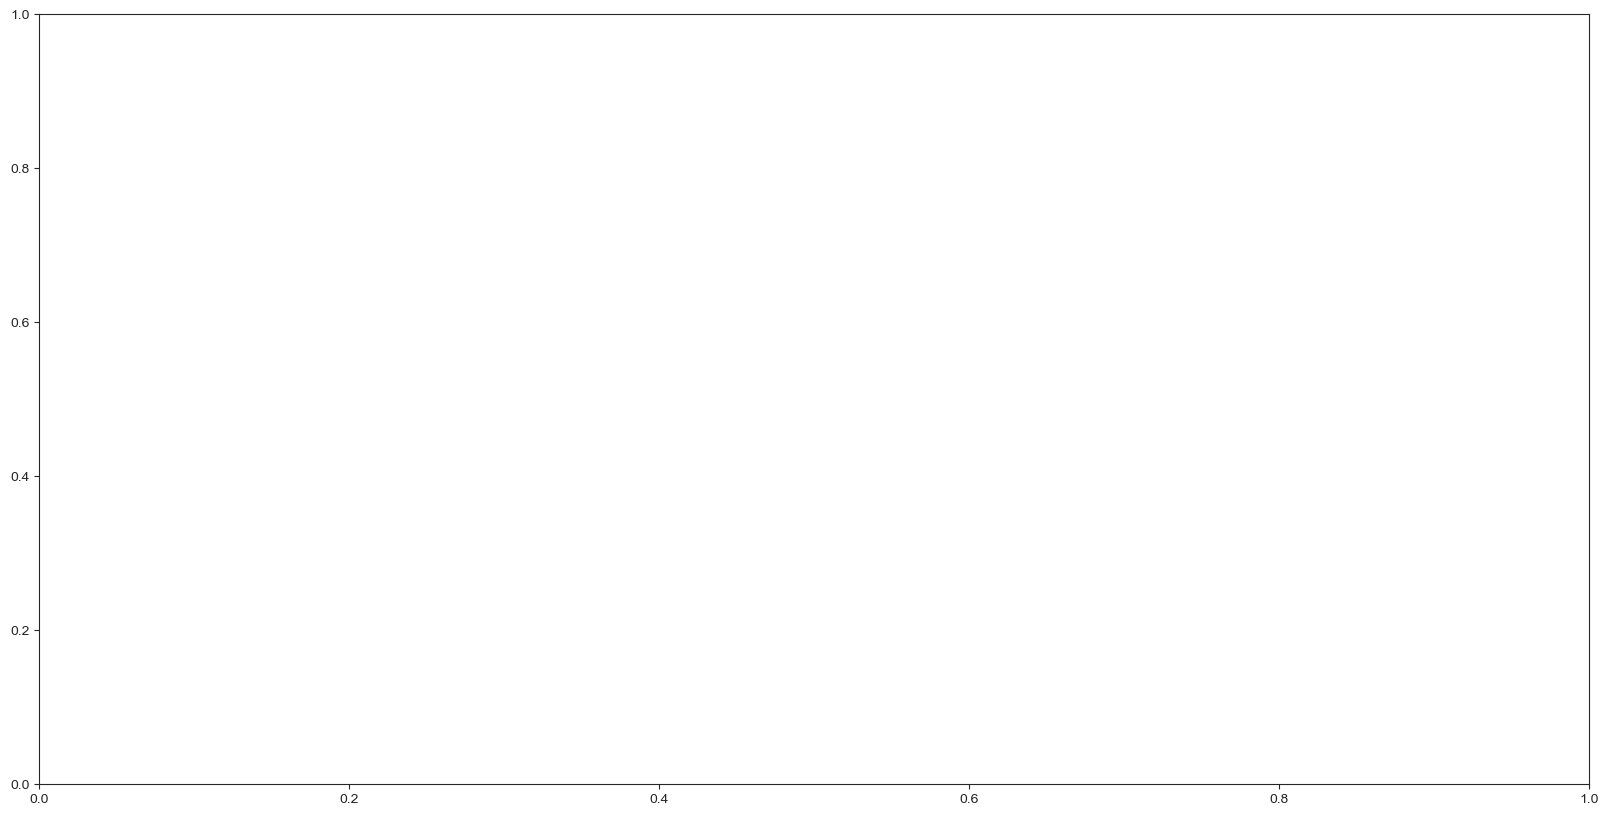

In [25]:
Repeats = [22,11,66,33,77]
Missequence= [26,23,12,13,62,61,32,31,36,71,76,73,27,17,67]
Other_Error = [24,25,28,14,15,18,64,65,68,34,35,38,74,75,78]

error_breakdown_df = pd.DataFrame({'animal':[],'group':[],'repeat_rate':[],'misseq_rate':[],'other_rate':[]})

for _, row in data.iterrows():
    #pull data from dfs:
    TransitionTypes_unfilt = np.array(row.trials_4000to5000_transitions)
    TransitionLatency_unfilt = np.array(row.trials_4000to5000_latency)

    # filter out transitions that are too slow (defined in preprocessing as 2s) and filter out transitions that are too fast (negative - this is probably a hardware error)   
    filter_mask = (np.array(TransitionLatency_unfilt) > 0) * (np.array(TransitionLatency_unfilt) < 2)
    TransitionTypes_Tfilt  = TransitionTypes_unfilt[filter_mask]
    TransitionLatency_Tfilt  = TransitionLatency_unfilt[filter_mask]

    _,e_inds = determine_seq_scores_and_indicies(list(TransitionTypes_Tfilt),Error+Neutral)
    errors_transitions = TransitionTypes_Tfilt[e_inds]

    repeat_score = determine_seq_scores_and_indicies(list(TransitionTypes_Tfilt),Repeats)[0]/len(errors_transitions)
    misseq_score = determine_seq_scores_and_indicies(list(TransitionTypes_Tfilt),Missequence)[0]/len(errors_transitions)
    other_score = determine_seq_scores_and_indicies(list(TransitionTypes_Tfilt),Other_Error)[0]/len(errors_transitions)

    tempt_df = pd.DataFrame({'animal':[row.animal],'group':[row.group],'repeat_rate':[repeat_score],'misseq_rate':[misseq_score],'other_rate':[other_score]})
    error_breakdown_df = error_breakdown_df.append(tempt_df)
    


c_mask = error_breakdown_df.group == 'control' 
l_mask = error_breakdown_df.group == 'lesions' 

type_ = list(error_breakdown_df[c_mask].group + '_repeat_rate') + list(error_breakdown_df[l_mask].group.values + '_repeat_rate')+list(error_breakdown_df[c_mask].group.values + '_misseq_rate') + list(error_breakdown_df[l_mask].group.values + '_misseq_rate')+list(error_breakdown_df[c_mask].group.values + '_other_rate') + list(error_breakdown_df[l_mask].group.values + '_other_rate')

scores = list(error_breakdown_df[c_mask].repeat_rate) + list(error_breakdown_df[l_mask].repeat_rate)+ list(error_breakdown_df[c_mask].misseq_rate) + list(error_breakdown_df[l_mask].misseq_rate)+ list(error_breakdown_df[c_mask].other_rate) + list(error_breakdown_df[l_mask].other_rate)

plt_df = pd.DataFrame({'group':type_,'score':scores})



fig, ax = plt.subplots(1, 1,figsize=(20,10))

color = 'grey'
x = [0.3] *7
ax.plot(x, error_breakdown_df[c_mask].repeat_rate,'o',markersize = 10, c = color)
x = [2.3] *7
ax.plot(x, error_breakdown_df[c_mask].misseq_rate,'o',markersize = 10, c = color)
x = [4.3] *7
ax.plot(x, error_breakdown_df[c_mask].other_rate,'o',markersize = 10, c = color)

color = '#A5D3B7'
x = [0.7] *9
ax.plot(x, error_breakdown_df[l_mask].repeat_rate,'o',markersize = 10, c = color)
x = [2.7] *9
ax.plot(x, error_breakdown_df[l_mask].misseq_rate,'o',markersize = 10, c = color)
x = [4.7] *9
ax.plot(x, error_breakdown_df[l_mask].other_rate,'o',markersize = 10, c = color)


ax=sns.boxplot( y = 'score', x = 'group', data = plt_df, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

ax.set_xticklabels(('control', 'lesion','control', 'lesion','control', 'lesion'), fontsize = 15)
ax.set_ylabel(('error rate'), fontsize = 15)

titles = ['repeats', 'missequence','other']

ax.set_title(titles[0], loc = 'left',fontsize = 20,pad = 30, color = 'k')
ax.set_title(titles[1], loc = 'center',fontsize = 20,pad = 30, color = 'k')
ax.set_title(titles[2], loc = 'right',fontsize = 20,pad = 30, color = 'k')


In [229]:
l_error_rates_breakdown= error_breakdown_df[error_breakdown_df.group == 'lesions']

In [230]:
l_error_rates_breakdown

animal    group  repeat_rate  misseq_rate  other_rate
0  EJT198  lesions     0.591600     0.396271    0.001810
0  EJT199  lesions     0.502146     0.450000    0.021674
0  EJT200  lesions     0.516239     0.454917    0.008176
0  EJT224  lesions     0.163169     0.162988    0.016643
0  EJT235  lesions     0.527442     0.451721    0.007628
0  EJT236  lesions     0.420307     0.519123    0.024850
0  EJT237  lesions     0.680884     0.304515    0.004611
0  EJT246  lesions     0.322589     0.656011    0.006077
0  EJT247  lesions     0.455735     0.536557    0.002102

In [32]:
l_error_rates_breakdown= error_breakdown_df[error_breakdown_df.group == 'lesions']

fig,ax, = plt.subplots(1, 1, figsize=(14, 8))

explode = (0.02, 0.02, 0.02)
colors = ['#2FA7C4','#E6BFC4','#ECEFB7']

prerepeat_mean = np.mean(l_error_rates_breakdown.repeat_rate.values)
premisseq_mean = np.mean(l_error_rates_breakdown.misseq_rate.values)
preother_mean= np.mean(l_error_rates_breakdown.other_rate.values)
total_prop = prerepeat_mean + premisseq_mean + preother_mean

y = np.array([prerepeat_mean/total_prop, premisseq_mean/total_prop,preother_mean/total_prop])
mylabels = ["Repeat", "Missequence", "Other" ]

ax.pie(y, labels = mylabels,explode =explode, colors=colors )

prerepeat_sem = scipy.stats.sem(l_error_rates_breakdown.repeat_rate.values)
premisseq_sem = scipy.stats.sem(l_error_rates_breakdown.misseq_rate.values)
preother_sem= scipy.stats.sem(l_error_rates_breakdown.other_rate.values)

print('repeat pre-proportion = ' + str(y[0]) + '   SEM = ' + str(prerepeat_sem))
print('misseq pre-proportion = ' + str(y[1]) + '   SEM = ' + str(premisseq_sem))
print('other pre-proportion = ' + str(y[2]) + '   SEM = ' + str(preother_sem))
print('-----------------')
# print('repeat post-proportion = ' + str(y2[0]) + '   SEM = ' + str(Postrepeat_sem))
# print('misseq post-proportion = ' + str(y2[1]) + '   SEM = ' + str(Postmisseq_sem))
# print('other post-proportion = ' + str(y2[2]) + '   SEM = ' + str(Postother_sem))
      
    
# SaveFig('lesion_error_breakdown_std.pdf',r'Z:\projects\Emmett\Documents\writeup\fig2_GRM2_lesions\figs\\')

NameError: name 'error_breakdown_df' is not defined

In [33]:
l_error_rates_breakdown= error_breakdown_df[error_breakdown_df.group == 'control']

fig,ax, = plt.subplots(1, 1, figsize=(14, 8))

explode = (0.02, 0.02, 0.02)
colors = ['#2FA7C4','#E6BFC4','#ECEFB7']

prerepeat_mean = np.mean(l_error_rates_breakdown.repeat_rate.values)
premisseq_mean = np.mean(l_error_rates_breakdown.misseq_rate.values)
preother_mean= np.mean(l_error_rates_breakdown.other_rate.values)
total_prop = prerepeat_mean + premisseq_mean + preother_mean

y = np.array([prerepeat_mean/total_prop, premisseq_mean/total_prop,preother_mean/total_prop])
mylabels = ["Repeat", "Missequence", "Other" ]

ax.pie(y, labels = mylabels,explode =explode, colors=colors )

prerepeat_sem = scipy.stats.sem(l_error_rates_breakdown.repeat_rate.values)
premisseq_sem = scipy.stats.sem(l_error_rates_breakdown.misseq_rate.values)
preother_sem= scipy.stats.sem(l_error_rates_breakdown.other_rate.values)

print('repeat pre-proportion = ' + str(y[0]) + '   SEM = ' + str(prerepeat_sem))
print('misseq pre-proportion = ' + str(y[1]) + '   SEM = ' + str(premisseq_sem))
print('other pre-proportion = ' + str(y[2]) + '   SEM = ' + str(preother_sem))
print('-----------------')
# print('repeat post-proportion = ' + str(y2[0]) + '   SEM = ' + str(Postrepeat_sem))
# print('misseq post-proportion = ' + str(y2[1]) + '   SEM = ' + str(Postmisseq_sem))
# print('other post-proportion = ' + str(y2[2]) + '   SEM = ' + str(Postother_sem))
      
    
# SaveFig('control_error_breakdown_std.pdf',r'Z:\projects\Emmett\Documents\writeup\fig2_GRM2_lesions\figs\\')

NameError: name 'error_breakdown_df' is not defined